<a href="https://colab.research.google.com/github/IslamJenishbekov/Custom_Classified_Tree/blob/main/Custom_classified_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

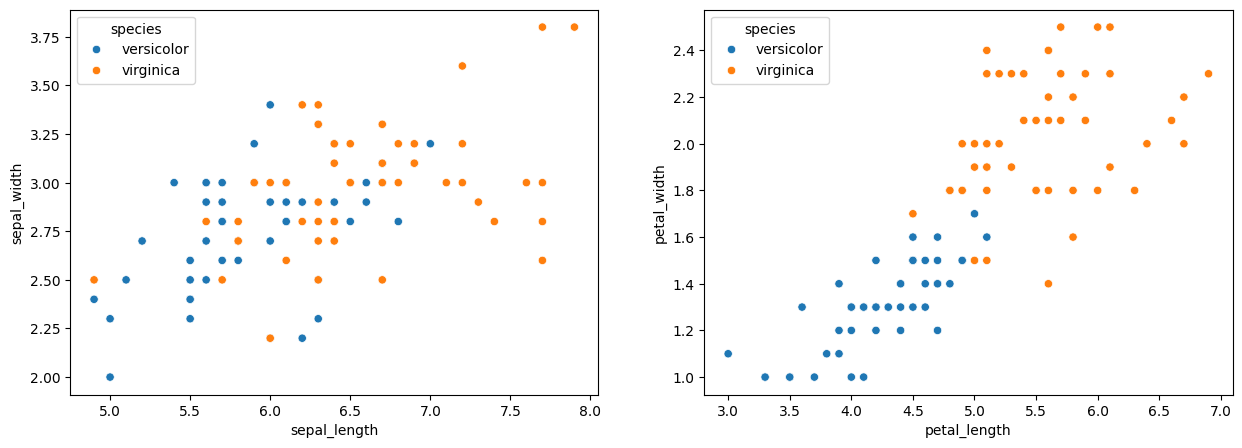

In [10]:
def choose_bin_class(class_1: str, class_2: str) -> pd.DataFrame:
  data = sns.load_dataset('iris')
  data = data.loc[(data['species'] == class_1) | (data['species'] == class_2)]
  return data

data = choose_bin_class('virginica', 'versicolor') #подставьте сюда 2 класса которые хотите разделить (setosa, versicolor, virginica)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(x=data.sepal_length, y=data.sepal_width, hue=data.species)
plt.subplot(1, 2, 2)
sns.scatterplot(x=data.petal_length, y=data.petal_width, hue=data.species)
# По графику стоит выбрать пару признаков по которым будет делать деление
# Для классов versicolor и virginica видим что лучше стоит выбрать petal_width и petal_length
data = data[['petal_width', 'petal_length', 'species']]

In [11]:
#конкретный узел
class Node:
    def __init__(self, feature_name, threshold, current_depth, data, entropy):
        self.feature_name = feature_name
        self.threshold = threshold
        self.current_depth = current_depth
        self.data = data
        self.entropy = entropy
        self.left = None
        self.right = None
        self.answer = None
        self.status = None

#само дерево
class ClassifiedTree:
    def __init__(self, max_depth):
        self.max_depth = max_depth
        self.columns = None
        self.root = None

    def fit(self, X, y):
        X = X.copy()
        X['species'] = y
        self.columns = X.columns.drop('species').unique()

        unique_labels = X['species'].unique()

        if len(self.columns) != 2:
            raise ValueError('X должен содержать ровно 2 признака!')

        if len(unique_labels) != 2:
            raise ValueError('y должен содержать ровно 2 уникальных значения!')

        column, threshold, entropy_res = self.split_best(X)
        if column is None:
            self.root = Node(None, None, 0, X, entropy_res)
            self.root.answer = X['species'].mode()[0]
            self.root.status = 'leaf'
        else:
            self.root = Node(column, threshold, 0, X, entropy_res)
            self.setting_nodes(self.root)

    def setting_nodes(self, root):
        column_name, threshold = root.feature_name, root.threshold
        left_data = root.data[root.data[column_name] <= threshold]
        right_data = root.data[root.data[column_name] > threshold]

        if left_data.shape[0] > 0:
            left_entropy = self.calculate_entropy_inside_node(left_data)
            left_column, left_threshold, left_entropy_res = self.split_best(left_data)
            if left_column is not None:
                left_node = Node(left_column, left_threshold, root.current_depth + 1, left_data, left_entropy_res)
                root.left = left_node

                if left_node.current_depth < self.max_depth:
                    self.setting_nodes(left_node)
            else:
                left_node = Node(None, None, root.current_depth + 1, left_data, left_entropy_res)
                left_node.answer = left_data['species'].mode()[0]
                left_node.status = 'leaf'
                root.left = left_node

        if right_data.shape[0] > 0:
            right_entropy = self.calculate_entropy_inside_node(right_data)
            right_column, right_threshold, right_entropy_res = self.split_best(right_data)
            if right_column is not None:
                right_node = Node(right_column, right_threshold, root.current_depth + 1, right_data, right_entropy_res)
                root.right = right_node

                if right_node.current_depth < self.max_depth:
                    self.setting_nodes(right_node)
            else:
                right_node = Node(None, None, root.current_depth + 1, right_data, right_entropy_res)
                right_node.answer = right_data['species'].mode()[0]
                right_node.status = 'leaf'
                root.right = right_node

    def split_best(self, data):
        if len(data['species'].unique()) < 2:
            return None, None, None

        column = None
        threshold = None
        best_gain = 0
        root_entropy = self.calculate_entropy_inside_node(data)

        for feature in self.columns:
            possible_thresholds = np.unique(data[feature])
            for t in possible_thresholds:
                left = data[data[feature] <= t]
                right = data[data[feature] > t]
                if len(left) == 0 or len(right) == 0:
                    continue

                left_entropy = self.calculate_entropy_inside_node(left)
                right_entropy = self.calculate_entropy_inside_node(right)
                weighted_entropy = self.calculate_weighted_entropy(left_entropy, right_entropy, len(left), len(right))
                gain = self.calculate_gain(root_entropy, weighted_entropy)
                if gain > best_gain:
                    best_gain = gain
                    column = feature
                    threshold = t

        if column is None:
            return None, None, root_entropy

        return column, threshold, root_entropy

    def calculate_entropy_inside_node(self, data):
        if len(data) == 0:
            return 0
        unique_labels = data['species'].unique()
        entropy = 0
        for label in unique_labels:
            p = len(data[data['species'] == label]) / len(data)
            if p > 0:
                entropy += -p * np.log2(p)
        return entropy

    def calculate_weighted_entropy(self, entropy_1, entropy_2, num_1, num_2):
        num_total = num_1 + num_2
        return (num_1 / num_total) * entropy_1 + (num_2 / num_total) * entropy_2

    def calculate_gain(self, root_entropy, weighted_entropy):
        return root_entropy - weighted_entropy


    def show_tree(self):
        print("ROOT: ", end="\t")
        self.show_node(self.root)

    def show_node(self, node):
        if node.status == "leaf":
            print(f"DEPTH: {node.current_depth} \t return: {node.answer}")
        else:
            print(f"DEPTH: {node.current_depth} \t {node.feature_name} <= {node.threshold}")
        if node.left is not None:
            print("Left:", end="\t")
            self.show_node(node.left)
        if node.right is not None:
            print("Right:", end="\t")
            self.show_node(node.right)

    def predict(self, X):
        predictions = []
        for _, row in X.iterrows():
            prediction = self.predict_single(row)
            predictions.append(prediction)
        return np.array(predictions)

    def predict_single(self, row):
        node = self.root
        while node.status != "leaf":
            if row[node.feature_name] <= node.threshold:
                node = node.left
            else:
                node = node.right
        return node.answer



In [14]:
tree = ClassifiedTree(max_depth=5)
tree.fit(data.drop('species', axis=1), data['species'])
y_pred = tree.predict(data.drop('species', axis=1))
(y_pred == data.species).sum() / len(data)

0.99

In [15]:
tree.show_tree()

ROOT: 	DEPTH: 0 	 petal_width <= 1.7
Left:	DEPTH: 1 	 petal_length <= 4.9
Left:	DEPTH: 2 	 petal_width <= 1.6
Left:	DEPTH: 3 	 return: versicolor
Right:	DEPTH: 3 	 return: virginica
Right:	DEPTH: 2 	 petal_width <= 1.5
Left:	DEPTH: 3 	 return: virginica
Right:	DEPTH: 3 	 petal_length <= 5.1
Left:	DEPTH: 4 	 return: versicolor
Right:	DEPTH: 4 	 return: virginica
Right:	DEPTH: 1 	 petal_length <= 4.8
Left:	DEPTH: 2 	 return: virginica
Right:	DEPTH: 2 	 return: virginica
